In [3]:
from sklearn.datasets import make_moons

m = 1000
X_moons, y_moons = make_moons(m, noise=0.1, random_state=42)

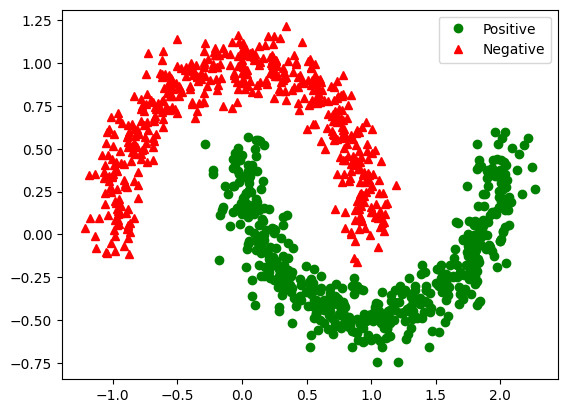

In [5]:
import matplotlib.pyplot as plt
plt.plot(X_moons[y_moons == 1, 0], X_moons[y_moons == 1, 1], 'go', label="Positive")
plt.plot(X_moons[y_moons == 0, 0], X_moons[y_moons == 0, 1], 'r^', label="Negative")
plt.legend()
plt.show()

In [6]:
import numpy as np
X_moons_with_bias = np.c_[np.ones((m, 1)), X_moons]
X_moons_with_bias[:5]

array([[ 1.        , -0.05146968,  0.44419863],
       [ 1.        ,  1.03201691, -0.41974116],
       [ 1.        ,  0.86789186, -0.25482711],
       [ 1.        ,  0.288851  , -0.44866862],
       [ 1.        , -0.83343911,  0.53505665]])

In [7]:
y_moons_column_vector = y_moons.reshape(-1, 1)
test_ratio = 0.2
test_size = int(m * test_ratio)
X_train = X_moons_with_bias[:-test_size]
X_test = X_moons_with_bias[-test_size:]
y_train = y_moons_column_vector[:-test_size]
y_test = y_moons_column_vector[-test_size:]

In [8]:
def random_batch(X_train, y_train, batch_size):
    rnd_indices = np.random.randint(0, len(X_train), batch_size)
    X_batch = X_train[rnd_indices]
    y_batch = y_train[rnd_indices]
    return X_batch, y_batch

In [9]:
X_batch, y_batch = random_batch(X_train, y_train, 5)
X_batch

array([[ 1.        ,  1.93189866,  0.13158788],
       [ 1.        ,  1.07172763,  0.13482039],
       [ 1.        , -1.01148674, -0.04686381],
       [ 1.        ,  0.02201868,  0.19079139],
       [ 1.        , -0.98941204,  0.02473116]])

In [10]:
y_batch

array([[1],
       [0],
       [0],
       [1],
       [0]])

In [11]:
import tensorflow as tf
import numpy as np
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)
reset_graph()

In [12]:
n_inputs = 2

In [14]:
X = tf.placeholder(tf.float32, shape=(None, n_inputs + 1), name="X")
y = tf.placeholder(tf.float32, shape=(None, 1), name="y")
theta = tf.Variable(tf.random_uniform([n_inputs + 1, 1], -1.0, 1.0, seed=42), name="theta")
logits = tf.matmul(X, theta, name="logits")
y_proba = 1 / (1 + tf.exp(-logits))

In [15]:
y_proba = tf.sigmoid(logits)

In [20]:
epsilon = 1e-7  # to avoid an overflow when computing the log
loss = -tf.reduce_mean(y * tf.math.log(y_proba + epsilon) + (1 - y) * tf.math.log(1 - y_proba + epsilon))

In [21]:
loss = tf.compat.v1.losses.log_loss(y, y_proba)  # uses epsilon = 1e-7 by default

In [22]:
learning_rate = 0.01
optimizer = tf.compat.v1.train.GradientDescentOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

In [24]:
init = tf.compat.v1.global_variables_initializer()

In [26]:
n_epochs = 1000
batch_size = 50
n_batches = int(np.ceil(m / batch_size))

with tf.compat.v1.Session() as sess:
    sess.run(init)

    for epoch in range(n_epochs):
        for batch_index in range(n_batches):
            X_batch, y_batch = random_batch(X_train, y_train, batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        loss_val = loss.eval({X: X_test, y: y_test})
        if epoch % 100 == 0:
            print("Epoch:", epoch, "\tLoss:", loss_val)

    y_proba_val = y_proba.eval(feed_dict={X: X_test, y: y_test})

2024-08-02 13:20:32.916143: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2024-08-02 13:20:32.916187: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      


Epoch: 0 	Loss: 0.79351133
Epoch: 100 	Loss: 0.34329292
Epoch: 200 	Loss: 0.30745557
Epoch: 300 	Loss: 0.29260933
Epoch: 400 	Loss: 0.28485358
Epoch: 500 	Loss: 0.28081775
Epoch: 600 	Loss: 0.27837232
Epoch: 700 	Loss: 0.27634045
Epoch: 800 	Loss: 0.27560374
Epoch: 900 	Loss: 0.27456817


In [27]:
y_proba_val[:5]

array([[0.5417928 ],
       [0.69843197],
       [0.51193625],
       [0.9908276 ],
       [0.49977282]], dtype=float32)

In [28]:
y_pred = (y_proba_val >= 0.5)
y_pred[:5]

array([[ True],
       [ True],
       [ True],
       [ True],
       [False]])

In [29]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_test, y_pred)

0.87

In [30]:
recall_score(y_test, y_pred)

0.8787878787878788

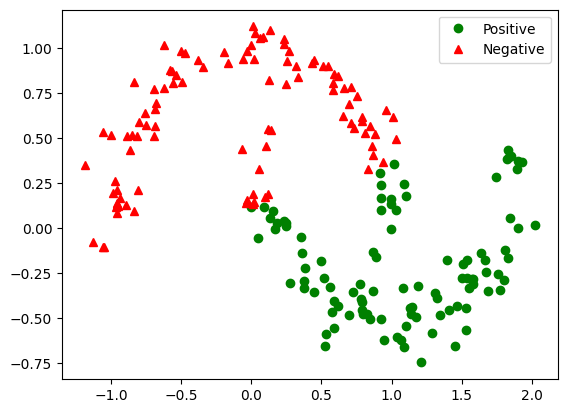

In [31]:
y_pred_idx = y_pred.reshape(-1) # a 1D array rather than a column vector
plt.plot(X_test[y_pred_idx, 1], X_test[y_pred_idx, 2], 'go', label="Positive")
plt.plot(X_test[~y_pred_idx, 1], X_test[~y_pred_idx, 2], 'r^', label="Negative")
plt.legend()
plt.show()

In [32]:
X_train_enhanced = np.c_[X_train,
                         np.square(X_train[:, 1]),
                         np.square(X_train[:, 2]),
                         X_train[:, 1] ** 3,
                         X_train[:, 2] ** 3]
X_test_enhanced = np.c_[X_test,
                        np.square(X_test[:, 1]),
                        np.square(X_test[:, 2]),
                        X_test[:, 1] ** 3,
                        X_test[:, 2] ** 3]

In [33]:
X_train_enhanced[:5]

array([[ 1.00000000e+00, -5.14696757e-02,  4.44198631e-01,
         2.64912752e-03,  1.97312424e-01, -1.36349734e-04,
         8.76459084e-02],
       [ 1.00000000e+00,  1.03201691e+00, -4.19741157e-01,
         1.06505890e+00,  1.76182639e-01,  1.09915879e+00,
        -7.39511049e-02],
       [ 1.00000000e+00,  8.67891864e-01, -2.54827114e-01,
         7.53236288e-01,  6.49368582e-02,  6.53727646e-01,
        -1.65476722e-02],
       [ 1.00000000e+00,  2.88850997e-01, -4.48668621e-01,
         8.34348982e-02,  2.01303531e-01,  2.41002535e-02,
        -9.03185778e-02],
       [ 1.00000000e+00, -8.33439108e-01,  5.35056649e-01,
         6.94620746e-01,  2.86285618e-01, -5.78924095e-01,
         1.53179024e-01]])

In [34]:
reset_graph()

In [35]:
def logistic_regression(X, y, initializer=None, seed=42, learning_rate=0.01):
    n_inputs_including_bias = int(X.get_shape()[1])
    with tf.name_scope("logistic_regression"):
        with tf.name_scope("model"):
            if initializer is None:
                initializer = tf.random_uniform([n_inputs_including_bias, 1], -1.0, 1.0, seed=seed)
            theta = tf.Variable(initializer, name="theta")
            logits = tf.matmul(X, theta, name="logits")
            y_proba = tf.sigmoid(logits)
        with tf.name_scope("train"):
            loss = tf.losses.log_loss(y, y_proba, scope="loss")
            optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
            training_op = optimizer.minimize(loss)
            loss_summary = tf.summary.scalar('log_loss', loss)
        with tf.name_scope("init"):
            init = tf.global_variables_initializer()
        with tf.name_scope("save"):
            saver = tf.train.Saver()
    return y_proba, loss, training_op, loss_summary, init, saver

In [36]:
from datetime import datetime

def log_dir(prefix=""):
    now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
    root_logdir = "tf_logs"
    if prefix:
        prefix += "-"
    name = prefix + "run-" + now
    return "{}/{}/".format(root_logdir, name)

In [38]:
n_inputs = 2 + 4
logdir = log_dir("logreg")

X = tf.placeholder(tf.float32, shape=(None, n_inputs + 1), name="X")
y = tf.placeholder(tf.float32, shape=(None, 1), name="y")

y_proba, loss, training_op, loss_summary, init, saver = logistic_regression(X, y)

file_writer = tf.compat.v1.summary.FileWriter(logdir, tf.compat.v1.get_default_graph())

In [40]:
import os
n_epochs = 10001
batch_size = 50
n_batches = int(np.ceil(m / batch_size))

checkpoint_path = "/tmp/my_logreg_model.ckpt"
checkpoint_epoch_path = checkpoint_path + ".epoch"
final_model_path = "./my_logreg_model"

with tf.Session() as sess:
    if os.path.isfile(checkpoint_epoch_path):
        # if the checkpoint file exists, restore the model and load the epoch number
        with open(checkpoint_epoch_path, "rb") as f:
            start_epoch = int(f.read())
        print("Training was interrupted. Continuing at epoch", start_epoch)
        saver.restore(sess, checkpoint_path)
    else:
        start_epoch = 0
        sess.run(init)

    for epoch in range(start_epoch, n_epochs):
        for batch_index in range(n_batches):
            X_batch, y_batch = random_batch(X_train_enhanced, y_train, batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        loss_val, summary_str = sess.run([loss, loss_summary], feed_dict={X: X_test_enhanced, y: y_test})
        file_writer.add_summary(summary_str, epoch)
        if epoch % 500 == 0:
            print("Epoch:", epoch, "\tLoss:", loss_val)
            saver.save(sess, checkpoint_path)
            with open(checkpoint_epoch_path, "wb") as f:
                f.write(b"%d" % (epoch + 1))

    saver.save(sess, final_model_path)
    y_proba_val = y_proba.eval(feed_dict={X: X_test_enhanced, y: y_test})
    os.remove(checkpoint_epoch_path)

file_writer.close()

2024-08-02 13:24:54.191331: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2024-08-02 13:24:54.191372: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      


Epoch: 0 	Loss: 0.629985
Epoch: 500 	Loss: 0.16122364
Epoch: 1000 	Loss: 0.1190321
Epoch: 1500 	Loss: 0.097329214
Epoch: 2000 	Loss: 0.08369793
Epoch: 2500 	Loss: 0.07437582
Epoch: 3000 	Loss: 0.06750214
Epoch: 3500 	Loss: 0.062206898
Epoch: 4000 	Loss: 0.058026787
Epoch: 4500 	Loss: 0.054562964
Epoch: 5000 	Loss: 0.051708277
Epoch: 5500 	Loss: 0.04923773
Epoch: 6000 	Loss: 0.047167283
Epoch: 6500 	Loss: 0.045376644
Epoch: 7000 	Loss: 0.043818746
Epoch: 7500 	Loss: 0.042374235
Epoch: 8000 	Loss: 0.041089173
Epoch: 8500 	Loss: 0.039970923
Epoch: 9000 	Loss: 0.03892026
Epoch: 9500 	Loss: 0.038010757
Epoch: 10000 	Loss: 0.037155703


In [41]:
y_pred = (y_proba_val >= 0.5)

In [42]:
precision_score(y_test, y_pred)

0.9797979797979798

In [43]:
recall_score(y_test, y_pred)

0.9797979797979798

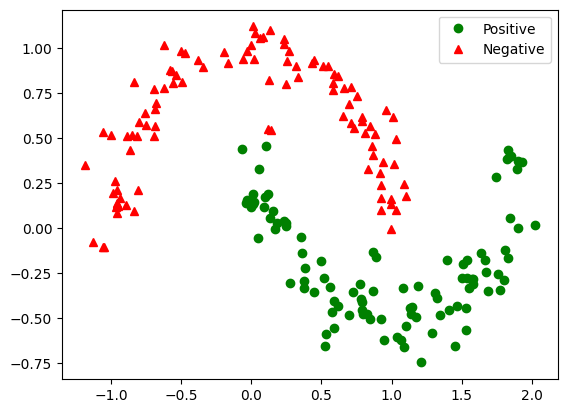

In [44]:
y_pred_idx = y_pred.reshape(-1) # a 1D array rather than a column vector
plt.plot(X_test[y_pred_idx, 1], X_test[y_pred_idx, 2], 'go', label="Positive")
plt.plot(X_test[~y_pred_idx, 1], X_test[~y_pred_idx, 2], 'r^', label="Negative")
plt.legend()
plt.show()

In [46]:
from scipy.stats import reciprocal

n_search_iterations = 10

for search_iteration in range(n_search_iterations):
    batch_size = np.random.randint(1, 100)
    learning_rate = reciprocal(0.0001, 0.1).rvs(random_state=search_iteration)

    n_inputs = 2 + 4
    logdir = log_dir("logreg")
    
    print("Iteration", search_iteration)
    print("  logdir:", logdir)
    print("  batch size:", batch_size)
    print("  learning_rate:", learning_rate)
    print("  training: ", end="")

    reset_graph()

    X = tf.placeholder(tf.float32, shape=(None, n_inputs + 1), name="X")
    y = tf.placeholder(tf.float32, shape=(None, 1), name="y")

    y_proba, loss, training_op, loss_summary, init, saver = logistic_regression(
        X, y, learning_rate=learning_rate)

    file_writer = tf.summary.FileWriter(logdir, tf.get_default_graph())

    n_epochs = 10001
    n_batches = int(np.ceil(m / batch_size))

    final_model_path = "./my_logreg_model_%d" % search_iteration

    with tf.Session() as sess:
        sess.run(init)

        for epoch in range(n_epochs):
            for batch_index in range(n_batches):
                X_batch, y_batch = random_batch(X_train_enhanced, y_train, batch_size)
                sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
            loss_val, summary_str = sess.run([loss, loss_summary], feed_dict={X: X_test_enhanced, y: y_test})
            file_writer.add_summary(summary_str, epoch)
            if epoch % 500 == 0:
                print(".", end="")

        saver.save(sess, final_model_path)

        print()
        y_proba_val = y_proba.eval(feed_dict={X: X_test_enhanced, y: y_test})
        y_pred = (y_proba_val >= 0.5)
        
        print("  precision:", precision_score(y_test, y_pred))
        print("  recall:", recall_score(y_test, y_pred))

file_writer.close()

Iteration 0
  logdir: tf_logs/logreg-run-20240802042659/
  batch size: 54
  learning_rate: 0.004430375245218265
  training: .

2024-08-02 13:26:59.191413: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2024-08-02 13:26:59.191444: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      


....................
  precision: 0.9797979797979798
  recall: 0.9797979797979798
Iteration 1
  logdir: tf_logs/logreg-run-20240802042806/
  batch size: 22
  learning_rate: 0.0017826497151386947
  training: .

2024-08-02 13:28:06.450945: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2024-08-02 13:28:06.450989: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      


....................
  precision: 0.9797979797979798
  recall: 0.9797979797979798
Iteration 2
  logdir: tf_logs/logreg-run-20240802043144/
  batch size: 74
  learning_rate: 0.00203228544324115
  training: .

2024-08-02 13:31:44.103768: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2024-08-02 13:31:44.103811: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      


....................
  precision: 0.9696969696969697
  recall: 0.9696969696969697
Iteration 3
  logdir: tf_logs/logreg-run-20240802043254/
  batch size: 58
  learning_rate: 0.004491523825137997
  training: .

2024-08-02 13:32:54.193479: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2024-08-02 13:32:54.193508: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      


....................
  precision: 0.9797979797979798
  recall: 0.9797979797979798
Iteration 4
  logdir: tf_logs/logreg-run-20240802043423/
  batch size: 61
  learning_rate: 0.07963234721775589
  training: .

2024-08-02 13:34:23.463184: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2024-08-02 13:34:23.463229: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      


....................
  precision: 0.9801980198019802
  recall: 1.0
Iteration 5
  logdir: tf_logs/logreg-run-20240802043548/
  batch size: 92
  learning_rate: 0.0004634250583294876
  training: .

2024-08-02 13:35:48.296642: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2024-08-02 13:35:48.296682: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      


....................
  precision: 0.912621359223301
  recall: 0.9494949494949495
Iteration 6
  logdir: tf_logs/logreg-run-20240802043646/
  batch size: 74
  learning_rate: 0.047706818419354494
  training: .

2024-08-02 13:36:46.138897: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2024-08-02 13:36:46.138928: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      


....................
  precision: 0.98
  recall: 0.98989898989899
Iteration 7
  logdir: tf_logs/logreg-run-20240802043758/
  batch size: 58
  learning_rate: 0.0001694044709524274
  training: .

2024-08-02 13:37:58.321946: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2024-08-02 13:37:58.321974: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      


....................
  precision: 0.9
  recall: 0.9090909090909091
Iteration 8
  logdir: tf_logs/logreg-run-20240802043928/
  batch size: 61
  learning_rate: 0.04171461199412461
  training: .

2024-08-02 13:39:28.361815: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2024-08-02 13:39:28.361843: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      


....................
  precision: 0.9801980198019802
  recall: 1.0
Iteration 9
  logdir: tf_logs/logreg-run-20240802044054/
  batch size: 92
  learning_rate: 0.00010742922968438615
  training: .

2024-08-02 13:40:54.334916: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2024-08-02 13:40:54.334950: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      


....................
  precision: 0.8823529411764706
  recall: 0.7575757575757576
